<h2>모델을 resnet에서 vgg16으로 변경했습니다.</h2>

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from sklearn.metrics import classification_report
import tensorflow as tf
import DataPreprocess as dp
from tensorflow import keras
from tqdm import tqdm

In [36]:
# path = "./AutismDataset/consolidated"
# Autistic_Data = os.listdir("./AutismDataset/consolidated/Autistic")
# Non_Autistic_Data = os.listdir("./AutismDataset/consolidated/Non_Autistic")

In [37]:
# DataPath = {"Path":list(map(lambda x: path + "/Autistic/" + x ,Autistic_Data)) + list(map(lambda x: path + f"/Non_Autistic/" + x ,Non_Autistic_Data))}
# df = pd.DataFrame(DataPath)
# df["Label"] = df["Path"].apply(lambda x : 1 if x.split("/")[-2] == "Autistic" else 0)
# df

전처리 적용

In [38]:


# for path in tqdm(df["Path"]):
#     try:
#         img = dp.preprocess(path)
#     except:
#         img = cv2.imread(path)
        
#     cv2.imwrite('/'.join(path.split("/")[:2]) + "/aft_preprocess/" + '/'.join(path.split("/")[3:]),img)



In [39]:
# path = "./AutismDataset/aft_preprocess"
# Autistic_Data = os.listdir(f"{path}/Autistic")
# Non_Autistic_Data = os.listdir(f"{path}/Non_Autistic")

# DataPath = {"Path":list(map(lambda x: path + "/Autistic/" + x ,Autistic_Data)) + list(map(lambda x: path + f"/Non_Autistic/" + x ,Non_Autistic_Data))}
# df = pd.DataFrame(DataPath)
# df["Label"] = df["Path"].apply(lambda x : 1 if x.split("/")[-2] == "Autistic" else 0)
# df.to_csv("afterPreprocess.csv")

In [1]:
dataset = pd.read_csv("afterPreprocess.csv")
dataset, target = dataset['Path'], dataset['Label']

NameError: name 'pd' is not defined

In [71]:
dataset.shape

(2940,)

In [72]:
x_train, x_test, y_train, y_test = train_test_split(dataset, target, test_size=0.2, shuffle=True, stratify=target, random_state=1004)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, shuffle=True, random_state=1004) # stratify=target 옵션을 주면 에러 발생

In [73]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2352,) (2352,)
(294,) (294,)


In [74]:
y_test.sum()/len(y_test), y_valid.sum()/len(y_valid) #클래스 값이 잘 나뉘어짐...

(0.5170068027210885, 0.48299319727891155)

데이터 파일 구조 변경

In [77]:
# import shutil

# for path in x_train:
# 	shutil.copy(path, "/".join(path.split("/")[:2] + ["train"] + path.split("/")[3:]))
 
# for path in x_test:
# 	shutil.copy(path, "/".join(path.split("/")[:2] + ["test"] + path.split("/")[3:]))
 
# for path in x_valid:
# 	shutil.copy(path, "/".join(path.split("/")[:2] + ["valid"] + path.split("/")[3:]))
 

./AutismDataset/aft_preprocess/Autistic/0264.jpg ./AutismDataset/train/Autistic/0264.jpg


데이터 제너레이터 선언

In [2]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    './AutismDataset/train', image_size=(224, 224),label_mode='binary'
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    './AutismDataset/test', image_size=(224, 224),label_mode='binary'
)

valid = tf.keras.preprocessing.image_dataset_from_directory(
    './AutismDataset/valid', image_size=(224, 224),label_mode='binary'
)


Found 2352 files belonging to 2 classes.
Found 294 files belonging to 2 classes.
Found 294 files belonging to 2 classes.


In [3]:
base_model = VGG16(include_top=False, input_shape=(224, 224 ,3), weights='imagenet')
base_model.trainable = True

In [4]:
for layer in base_model.layers[:]:
  print(layer.name, layer.trainable)

input_layer True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [5]:
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(base_model.input, outputs)

In [6]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 14,977,857 (57.14 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# categorical_crossentropy
model.compile(optimizer = "adam",
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])

checkpoint_path = "model_save/checkpoint/ckp.vgg16_adam{epoch:04d}.weights.h5"
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0)
ckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            save_freq="epoch",
                                            verbose=1)

# 모델 fitting
history = model.fit(train,validation_data=valid, epochs = 10, batch_size=128, callbacks=[reduce_lr,ckpoint])
model.save("./model_save/vgg16_adam.keras")

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4897 - loss: 4.8809
Epoch 1: saving model to model_save/checkpoint/ckp.vgg16_adam0001.weights.h5
74/74 ━━━━━━━━━━━━━━━━━━━━ 656s 9s/step - accuracy: 0.4899 - loss: 4.8419 - val_accuracy: 0.5034 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5005 - loss: 0.6937
Epoch 2: saving model to model_save/checkpoint/ckp.vgg16_adam0002.weights.h5
74/74 ━━━━━━━━━━━━━━━━━━━━ 627s 8s/step - accuracy: 0.5004 - loss: 0.6937 - val_accuracy: 0.5068 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4991 - loss: 0.6933
Epoch 3: saving model to model_save/checkpoint/ckp.vgg16_adam0003.weights.h5
74/74 ━━━━━━━━━━━━━━━━━━━━ 636s 9s/step - accuracy: 0.4992 - loss: 0.6933 - val_accuracy: 0.4830 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 4/10
58/74 ━━━━━━━━━━━━━━━━━━━━ 2:11 8s/step - accuracy: 0.4855 - loss: 0.6933

KeyboardInterrupt: 

In [8]:
history.history.keys()

def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()


plot_history(history) #해볼 것들 dense 레이어 추가해서 모델 복잡도 올리기 (분류기 성능이 안나오는 것 같음)

NameError: name 'history' is not defined

In [87]:
# model.save("./model_save/modleWithOneLabel.keras")

In [15]:
# model = keras.models.load_model("./model_save/finalmodel2.keras")
# model.load_weights("./model_save/checkpoint/ckp.model0006.weights.h5")

In [9]:
test_loss, test_acc = model.evaluate(test, verbose=2)

print('\n테스트 정확도:', test_acc)

10/10 - 8s - 807ms/step - accuracy: 0.7245 - loss: 0.6429

테스트 정확도: 0.7244898080825806


In [10]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report


true_labels = []
for images, labels in test:
    true_labels.extend(labels.numpy())


Y_pred = model.predict(test)

threshold = 0.5 #모델이 자폐라고 판단할 확률 ( 모델이 자폐라고 확신하는 정도)
val_preds = (Y_pred > threshold).astype(int)
val_trues = true_labels

print(classification_report(val_trues, val_preds))

2024-05-02 11:52:29.453682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 846ms/step
              precision    recall  f1-score   support

           0       0.47      0.32      0.38       152
           1       0.46      0.61      0.52       142

    accuracy                           0.46       294
   macro avg       0.46      0.46      0.45       294
weighted avg       0.46      0.46      0.45       294



In [11]:
real_data = dp.preprocess("real_data.png")
input = np.expand_dims(real_data, axis=0)
real_data.shape

(224, 224, 3)

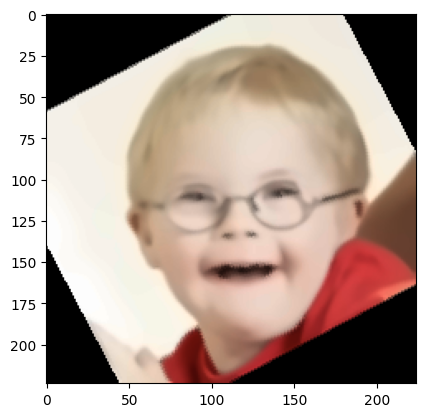

In [12]:
plt.imshow(cv2.cvtColor(real_data, cv2.COLOR_BGR2RGB))

In [13]:
result = model.predict(input)
val_preds = "자폐" if (result > 0.7).astype(int) == 1 else "정상"
val_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


'정상'